In [1]:
from __future__ import print_function,division

from builtins import range,input

In [6]:
from keras.layers import Input, Lambda,Dense,Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

In [10]:
epochs = 5
batch_size = 32
image_size = [100,100]

train_path = "fruits-360-original-size/Training"
validation_path = "fruits-360-original-size/Validation"

image_file = glob(train_path+'/*/*.jp*g')
validation_image_files = glob(validation_path+'/*/*.jp*g')

no_of_class = glob(train_path+'/*')

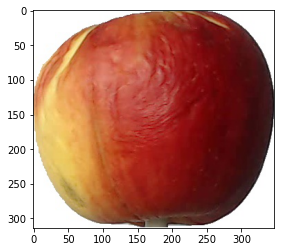

In [11]:
plt.imshow(image.load_img(np.random.choice(image_file)))
plt.show()

In [12]:
vgg = VGG16(input_shape=image_size+[3],weights='imagenet',include_top=False)

for layers in vgg.layers:  # do not train already existing layers
    layers.trainable = False
    
    
x = Flatten()(vgg.output)
prediction = Dense(len(no_of_class),activation='softmax')(x)

model = Model(inputs=vgg.input,outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [13]:
model.compile(
loss = 'categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

In [14]:
#Using image data generator to help generalization
gen = ImageDataGenerator(
rotation_range = 10,
width_shift_range = 0.1,
height_shift_range=0.1,
zoom_range = 0.2,
horizontal_flip = True,
vertical_flip = True,
preprocessing_function = preprocess_input
)

In [15]:
test_generator = gen.flow_from_directory(validation_path,target_size=image_size)
print(test_generator.class_indices)

Found 3114 images belonging to 24 classes.
{'apple_6': 0, 'apple_braeburn_1': 1, 'apple_crimson_snow_1': 2, 'apple_golden_1': 3, 'apple_golden_2': 4, 'apple_golden_3': 5, 'apple_granny_smith_1': 6, 'apple_hit_1': 7, 'apple_pink_lady_1': 8, 'apple_red_1': 9, 'apple_red_2': 10, 'apple_red_3': 11, 'apple_red_delicios_1': 12, 'apple_red_yellow_1': 13, 'apple_rotten_1': 14, 'cabbage_white_1': 15, 'carrot_1': 16, 'cucumber_1': 17, 'cucumber_3': 18, 'eggplant_violet_1': 19, 'pear_1': 20, 'pear_3': 21, 'zucchini_1': 22, 'zucchini_dark_1': 23}


In [16]:
labels=[None]*len(test_generator.class_indices)
for k,v in test_generator.class_indices.items():
    labels[v] = k
    
    


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min -113.36861 max: 151.061


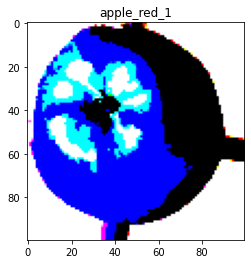

In [18]:
#VGG weights being BGR
#Reordering the channels
for x,y in test_generator:
    print("min",x[0].min(),"max:",x[0].max())
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break

In [21]:
train_generator = gen.flow_from_directory(
train_path,
target_size=image_size,
shuffle=True,
batch_size=batch_size)

Found 6231 images belonging to 24 classes.


In [22]:
validation_generator = gen.flow_from_directory(
validation_path,
target_size=image_size,
shuffle=True,
batch_size=batch_size)

Found 3114 images belonging to 24 classes.


In [24]:
#Fit the model
r =model.fit_generator(
train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    steps_per_epoch = len(image_file) // batch_size,
    validation_steps = len(validation_image_files) // batch_size
)

<ipython-input-24-71cdcd7557ea>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r =model.fit_generator(


Epoch 1/5
194/194 [==============================] - 221s 1s/step - loss: 3.3043 - accuracy: 0.7795 - val_loss: 0.6285 - val_accuracy: 0.9301
Epoch 2/5
194/194 [==============================] - 208s 1s/step - loss: 0.7642 - accuracy: 0.9260 - val_loss: 0.8488 - val_accuracy: 0.9385
Epoch 3/5
194/194 [==============================] - 201s 1s/step - loss: 0.4683 - accuracy: 0.9561 - val_loss: 0.3058 - val_accuracy: 0.9688
Epoch 4/5
194/194 [==============================] - 206s 1s/step - loss: 0.3335 - accuracy: 0.9653 - val_loss: 0.2683 - val_accuracy: 0.9713
Epoch 5/5
194/194 [==============================] - 206s 1s/step - loss: 0.3286 - accuracy: 0.9692 - val_loss: 0.0883 - val_accuracy: 0.9865


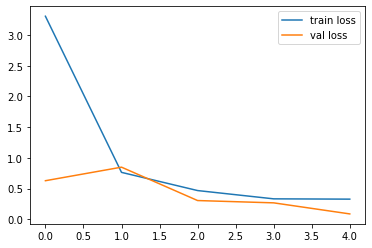

In [25]:
plt.plot(r.history['loss'],label='train loss')
plt.plot(r.history['val_loss'],label='val loss')
plt.legend()
plt.show()

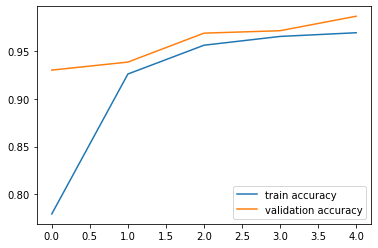

In [28]:
plt.plot(r.history['accuracy'],label='train accuracy')
plt.plot(r.history['val_accuracy'],label='validation accuracy')
plt.legend()
plt.show()